## 1. 循环神经网络 Recurrent Neural Networks
---

循环神经网络是一个序列模型。

序列模型，顾名思义，模型是一个序列，即$x_1, x_2, \cdots, x_{t-1}, x_t$

模型的目标是在给定$x_1, x_2, \cdots, x_{t-1}$的情况下预测$x_t$

### 1.1 一个经典的时序模型

在时间序列分析中，ARIMA(Autoregressive Integrated Moving Average)是一种常见的分析方法，也是一个预测模型。

**ARIMA假设1（截断）**：$t$时刻的序列状态$x_t$只和之前的$p$个时刻有关，即进行了截断。这是有道理的，一般情况下，我们可以认为过去发生的事情，离我们越近的关系越大，越远的就关系越小，超过一定时间范围，就可以认为没有关系了。这个思想和核密度估计是一样的，只是那里不是时间，而是位置，而且是双侧。

**ARIMA假设2（状态线性相关）**：$t$时刻的序列状态和之前的$p$个时刻状态线性相关。

于是，$x_t$可以表示为：$$x_t =C + \sum_{i=1}^{p}\phi_{i}x_{t-i}+\varepsilon_t $$ 
- $x_t$：$t$时刻序列的状态
- $C$：常数项
- $\phi_i$：自回归系数
- $\varepsilon_t$：白噪声，均值为0，方差恒定

这构成了ARIMA的AR(p)部分

**ARIMA假设3（残差线性相关）**：$t$时刻的残差和之前的q个时刻的残差线性相关。
于是，$x_t$可以表示为：
$$x_t=\mu+\sum_{i=1}^q\theta_i\varepsilon_{t-i}+\varepsilon_t$$
- $x_t$：$t$时刻序列的状态
- $\mu$：序列均值
- $\theta_i$：移动平均系数
- $\varepsilon_{t-i}$：历史时刻的误差项

这构成了ARIMA的MA(q)部分

**ARIMA假设4（差分平稳）**：在经过d阶差分后，序列满足平稳性，即均值、方差不随时间变化。

时间序列分析中，靠量的因素有四部分：趋势性、季节性、周期性和噪声。差分用于消除趋势、季节性等非平稳因素的影响。

差分的另一个视角可以看作是导数，d阶差分平稳可以看作是一个d阶的多项式。1阶差分平稳表示一个等差数列，即线性相关；二阶差分平稳表示一个二次多项式，即二次平稳，以此类推。

令 $Lx_t=x_{t-1}$，其中L为滞后(Lag)算子。于是，d阶差分可以表示为：
$$ \Delta^dx_t=(1-L)^dx_t$$

将三个部分整合，得到经典的ARMA(p, d, q)模型：
$$(1-\sum_{i=1}^p\phi_iL^i)(1-L)^dx_t=(1+\sum_{i=1}^q\theta_iL^i)\varepsilon_t $$

下面是一些常见的情况：

ARIMA(1,0,0) ，表示一阶自回归模型(first-order autoregressive model)，和AR(1)相同。即：$x_t=\phi_1x_{t-1}+\varepsilon_t$

ARIMA(0,1,0) ，表示随机游走(random walk) 。即：$x_t=x_{t-1}+\varepsilon_t$

ARIMA(1,1,0) ，表示差分一阶自回归模型(differenced first-order autoregressive model)。即：$\Delta x_t=\phi_1\Delta x_{t-1}+\epsilon_t$

ARIMA(0,1,1) 不带常数项，表示简单指数平滑(simple exponential smoothing models)。 即：$\Delta x_t=\varepsilon_t -\theta_1\varepsilon_{t-1}$

ARIMA(0,1,1) 带常数项，表示带增长的简单指数平滑(simple exponential smoothing models with growth)。即：$\Delta x_t=c + \varepsilon_t -\theta_1\varepsilon_{t-1}$

p, d, q作为未知的超参数根据一定的准则进行搜索。

### 1.2 隐藏状态

从上面经典的时序模型可以看出，该模型是递归性质的。

用隐藏状态来总结以前的信息，使得某时刻的状态之取决于前一时刻隐藏状态。

用概率的方式可以表示为：$x_t \sim P(x_t|h_{t-1})$

In [2]:
from IPython.display import Image, display
url = 'https://zh.d2l.ai/_images/rnn.svg'
display(Image(url=url, width=600))

这便是循环神经网络。

当然也可以从概率图模型的视角来看，循环神经网络就是一个规整的贝叶斯网，如果只有一个隐藏层，就是隐马尔科夫模型。

### 1.3 数学表达式

$t$时刻的隐藏输出：$H_t = \phi(W_{hh}H_{t-1}+W_{xh}X_t+b)$

$t$时刻的预测输出：$\hat X_t = \phi(W_{hx}H_{t}+b)$

用分块矩阵乘法重新表示下$H_t$：$H_t = \phi(\left[\begin{array}{c|r}W_{hh} & W_{xh}\end{array}\right] \left[\begin{array}{cc|r}H_{t-1}\\X_t\end{array}\right]+b)$

用$\hat X_t$和$X_t$之间的交叉熵作为损失函数

假设序列总长度为n，则成本函数为n个输入的平均交叉熵损失

历史原因，自然语言处理的科学家更喜欢使用一个叫做困惑度（perplexity）的量，是指数化的成本函数

## 2 词编码

词编码的方式有很多：

**传统统计方法**：one-hot编码；词袋模型（Bag of Words, BoW）；TF-IDF（词频-逆文档频率）

**词嵌入**：Word2Vec；GloVe（Global Vectors）；FastText

**子词编码（Subword Tokenization）**：Byte Pair Encoding (BPE)；WordPiece；SentencePiece

---

**one-hot编码**：向量的长度等于词汇表大小。根据词汇表大小，每个词给一个稀疏的二进制向量，明确区分不同词（所有向量互相正交）。特点是高维稀疏。

**词袋模型**：向量的长度等于词汇表大小。把一段文本看作一个“装词汇的袋子”，忽略词的位置和顺序，只统计每个词出现的次数。同义词会被视为完全不同的特征。可以用N-gram来改进。

**TF-IDF（词频-逆文档频率）**：向量的长度等于词汇表大小。稠密浮点数向量，每个元素是词的TF-IDF权重。实际向量是高度稀疏的（大部分词权重为0）

第一步：计算词频（TF, Term Frequency）

$$TF(t, d) = \frac{词t在文档d中出现的次数}{文档d的总词数}$$

第二步：计算逆文档频率（IDF, Inverse Document Frequency）

$$IDF(t) = log(\frac{总文档数N}{包含词t的文档数})$$

第三步：计算TF-IDF权重

$$TF-IDF(t,d)=TF(t,d)×IDF(t)$$

简单有效，能自动突出关键词（如专业术语、稀有词）

对超短文本（如推文）效果较差（词频统计不可靠）

---

**Word2Vec**：先制定词的维数，比如300，再通过网络进行训练。gensim库可实现。有Skip-gram（跳字模型）和CBOW（连续词袋模型）两种模式。核心思想是：“相似的词出现在相似的上下文中”。

**GloVe**：核心思想是：一个词的语义可以通过它在整个语料库中与其他词的共现（共同出现）模式来捕捉。

**FastText**：核心思想是：词的语义由其组成部分决定。词=“apple”，n=3 → 子词：\["<ap", "app", "ppl", "ple", "le>"]

---

**Byte Pair Encoding (BPE)**：通过合并高频字符对，逐步将词拆分为更小的子词单元。BPE本身不生成词向量，需结合其他模型（如Word2Vec、BERT）
BBPE则是直接采用了字节级别的类似算法（Byte，8位二进制数据）。

**WordPiece**：合并对语言模型（如预测下一个词）帮助最大的字符对，而不是看频率。WordPiece本身不生成词向量，需结合上下文模型（如BERT）

**SentencePiece**：从所有可能的字符和常见子词组合中随机生成一个较大的候选词汇表。通过期望最大化（EM）算法，逐步淘汰低概率子词，最终保留目标大小的词汇表。将文本直接视为一串字符，无需预分词，尤其适合中文、日文等无空格语言


## 3. 文本分类

基于以 imdb 数据集，实现了一个基本的 RNN 文本分类任务

### 3.1 导入必要的包

In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizer
import torch.nn as nn
import torch.optim as optim
from IPython.display import display, clear_output

### 3.2 设定超参数

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-3 #学习率
batch_size = 16 # 批次大小
epochs = 20 # 训练轮次

### 3.3 处理数据

In [3]:
# 加载IMDB数据集
dataset = load_dataset("imdb", cache_dir='./data')

# 打印数据集的结构
print(dataset)
# 查看数据集的字段名称
print(dataset['train'].column_names)
# 查看数据集的特征类型
print(dataset['train'].features)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}


In [4]:
len(dataset['train'][11]['text'])

723

In [5]:
print(dir(dataset))

['__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_values_features', '_check_values_type', 'align_labels_with_mapping', 'cache_files', 'cast', 'cast_column', 'class_encode_column', 'cleanup_cache_files', 'clear', 'column_names', 'copy', 'data', 'filter', 'flatten', 'flatten_indices', 'formatted_as', 'from_csv', 'from_json', 'from_parquet', 'from_text', 'fromkeys', 'get', 'items', 'keys', 'load_from_disk', 'map', 'num_columns', 'num_rows', 'pop', 'popitem', 'push_to_hub', 'remove_columns', 'rename_co

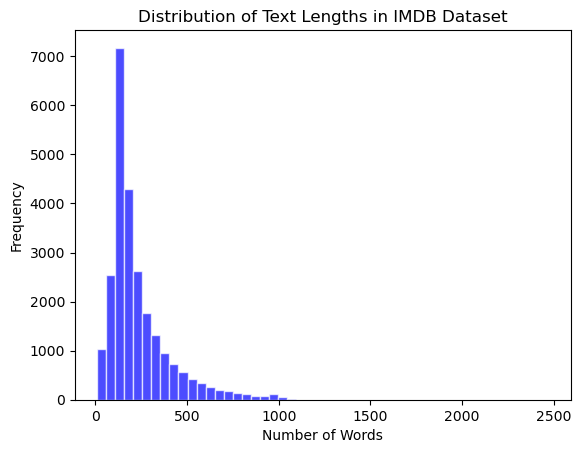

In [6]:
import matplotlib.pyplot as plt

# 获取训练集中的文本
texts = dataset['train']['text'] 
lengths = [len(text.split()) for text in texts]  # 计算每条文本的单词数量

# 绘制文本长度的分布
plt.hist(lengths, bins=50, color='blue', alpha=0.7, edgecolor='white')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in IMDB Dataset')
plt.show()

In [7]:
# 分词器
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cache_dir='./cache') # BERT Tokenizer 使用的是 WordPiece 算法
type(tokenizer)

transformers.models.bert.tokenization_bert.BertTokenizer

In [8]:
# 示例
text = "The Hub has support for dozens of libraries in the Open Source ecosystem. \
Thanks to the huggingface_hub Python library, it’s easy to enable sharing your models on the Hub. \
The Hub supports many libraries, and we’re working on expanding this support. \
We’re happy to welcome to the Hub a set of Open Source libraries that are pushing Machine Learning forward."

# 分词
tokens = tokenizer.tokenize(text)
print("Tokens:", len(tokens), tokens)

Tokens: 75 ['the', 'hub', 'has', 'support', 'for', 'dozens', 'of', 'libraries', 'in', 'the', 'open', 'source', 'ecosystem', '.', 'thanks', 'to', 'the', 'hugging', '##face', '_', 'hub', 'python', 'library', ',', 'it', '’', 's', 'easy', 'to', 'enable', 'sharing', 'your', 'models', 'on', 'the', 'hub', '.', 'the', 'hub', 'supports', 'many', 'libraries', ',', 'and', 'we', '’', 're', 'working', 'on', 'expanding', 'this', 'support', '.', 'we', '’', 're', 'happy', 'to', 'welcome', 'to', 'the', 'hub', 'a', 'set', 'of', 'open', 'source', 'libraries', 'that', 'are', 'pushing', 'machine', 'learning', 'forward', '.']


In [9]:
def preprocess_function(dataset):
    return tokenizer(dataset['text'], padding='max_length', truncation=True, max_length=300)

encoding = tokenizer(text, padding=True, truncation=True, max_length=20, return_tensors="pt")
print(encoding)

{'input_ids': tensor([[  101,  1996,  9594,  2038,  2490,  2005,  9877,  1997,  8860,  1999,
          1996,  2330,  3120, 16927,  1012,  4283,  2000,  1996, 17662,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [10]:
# 应用预处理
train_dataset = dataset['train'].map(preprocess_function, batched=True)
test_dataset = dataset['test'].map(preprocess_function, batched=True)

# 转换为 torch.Tensor
def format_dataset(dataset):
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    return dataset

# 应用格式化
train_dataset = format_dataset(train_dataset)
test_dataset = format_dataset(test_dataset)

# 定义 collate_fn
def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'label': labels
    }

# 创建 DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [11]:
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[  101,  4283,  2000,  ...,     0,     0,     0],
        [  101,  2028, 12027,  ...,  1996,  3382,   102],
        [  101,  8130,  2039,  ...,     0,     0,     0],
        ...,
        [  101,  1000,  2027,  ...,     0,     0,     0],
        [  101,  2348,  1045,  ...,  8645,  5691,   102],
        [  101, 14414,  2003,  ...,  2006, 14414,   102]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), 'label': tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1])}


### 3.4 定义网络

In [12]:
# 定义 RNN 模型
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.rnn = nn.RNN(128, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # 获取序列的最后一个输出
        out = self.fc(out)
        return self.softmax(out)

1. 初始化embedding权重矩阵$W_e\in \mathbb{R}^{30000\times128}$

2. 输入词索引矩阵，大小（batch_size=128, seq_len=300）

3. 索引得到词向量矩阵，大小（batch_size=128, seq_len=300，embedding_dim=128），即$X\in\mathbb{R}^{128\times300\times128}$

4. $t\in\mathbb N\in[1, seq\_len=300]$，取$t=1$时刻的$x$，即$x_{t=1}\in\mathbb{R}^{128\times128}$

6. 初始化$h_{t=0}$，大小（num_layers=1, batch_size=128, hidden_dim=128），即$h_{t=0}\in\mathbb{R}^{1\times128\times128}$

7. 初始化$W_{hh}, W_{xh},b_{hh}, b_{xh}$

8. $h_{t=1} = \phi(W_{hh}h_{t=0} + b_{hh}+W_{xh}x_1  + b_{xh}  )$

9. $\hat x_{t=1} = \phi(W_{hx}h_{t=1} + b_{hx}  )$

10. 循环直至：$h_{t=300}$

11. RNN输出：$output\in\mathbb{R}^{128\times300\times128}$

12. 取最后一个时间步的隐藏状态$h_{t=300}\in\mathbb{R}^{128\times1\times128}$进入全连接层

13. 计算损失函数

14. BP反向传播流经嵌入层，更新对应的嵌入向量

15. 更新所有参数

### 3.5 实例化模型

In [13]:
# BERT的词汇表大小为 30,000，隐藏层维度为128，输出类别数为2（正面或负面）
model = RNNModel(input_dim=30000, hidden_dim=128, output_dim=2)

In [14]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
RNNModel                                 --
├─Embedding: 1-1                         3,840,000
├─RNN: 1-2                               33,024
├─Linear: 1-3                            258
├─Softmax: 1-4                           --
Total params: 3,873,282
Trainable params: 3,873,282
Non-trainable params: 0

### 3.6 选择损失函数和优化器

In [15]:
# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model.to(device)
scaler = torch.amp.GradScaler()

In [16]:
# 定义训练函数
def train(epoch):
    model.train()
    train_loss = 0
    correct_num = 0
    total_num = 0
    
    # 遍历训练数据
    for batch in train_dataloader:
        # 将数据和标签挪到GPU  
        data = batch['input_ids'].to(device)
        label = batch['label'].to(device)
        
        optimizer.zero_grad() # 梯度清理
        with torch.amp.autocast(device_type='cuda'):
            output = model(data)
            loss = criterion(output, label)
        # 使用 GradScaler 进行 loss 反向传播
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()  #计算总损失
        preds = torch.argmax(output, dim=1)
        correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
        total_num += label.size(0) # 总预测数量

        #手动释放显存
        del data, label, output, loss
        torch.cuda.empty_cache()

    train_loss = train_loss/len(train_dataloader) # 计算平均训练损失
    accuracy = correct_num/total_num # 计算准确率
    train_losses.append(train_loss)
    train_accuracies.append(accuracy)
    print(f'Epoch:{epoch}\tTraining Loss:{train_loss:.6f}, Accuracy:{accuracy:.6f}') # 输出信息

In [19]:
# 定义验证函数并初始化
def evaluate(epoch): 
    model.eval() # 验证模式
    evaluate_loss = 0 #累积验证损失
    correct_num = 0 
    total_num = 0 
    
    # 禁用梯度
    with torch.no_grad():
        # 遍历测试数据
        for batch in test_dataloader: 
            # 将数据和标签挪到GPU  
            data = batch['input_ids'].to(device)
            label = batch['label'].to(device)
            with torch.amp.autocast(device_type='cuda'):  # 同样使用半精度
                output = model(data)
                loss = criterion(output, label)

            evaluate_loss += loss.item() # 累积总损失
            preds = torch.argmax(output, dim=1)
            correct_num += torch.eq(preds, label).sum().item() # 预测正确数量
            total_num += label.size(0) # 总预测数量
    accuracy = correct_num/total_num # 计算准确率
    evaluate_loss = evaluate_loss/total_num # 计算平均验证损失
    test_accuracies.append(accuracy)
    print(f'Epoch:{epoch}\tValidation Loss:{evaluate_loss:.6f}, Accuracy:{accuracy:.6f}') #打印输出信息

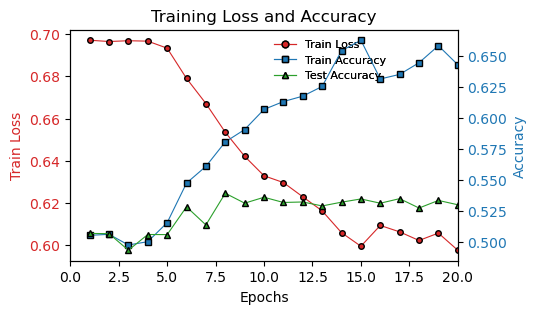

In [20]:
# 初始化数据
train_losses = []
train_accuracies = []
test_accuracies = []

# 设置 x 轴范围
initial_x_range = 10
x_range = initial_x_range  # 初始的 x 轴范围

# 画图函数
def plot_graph(epoch):
    global x_range

    # 如果 epoch 数量大于 x 轴范围的上限，就扩展 x 轴范围
    if epoch > x_range:
        x_range += 10
    
    clear_output(wait=True)  # 清除上一次的图表
    
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 绘制训练损失（左 y 轴）
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Train Loss', color='tab:red')
    ax1.plot(range(1, len(train_losses) + 1), train_losses, color='tab:red', label='Train Loss', linewidth=0.8, marker='o', markersize=4, markeredgecolor='black')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_xlim(0, x_range)

    # 创建右侧 y 轴（准确率）
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, color='tab:blue', label='Train Accuracy', linewidth=0.8, marker='s', markersize=4, markeredgecolor='black')
    ax2.plot(range(1, len(test_accuracies) + 1), test_accuracies, color='tab:green', label='Test Accuracy', linewidth=0.8, marker='^', markersize=4, markeredgecolor='black')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # 获取 ax1 和 ax2 的图例并合并
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles = handles1 + handles2
    labels = labels1 + labels2

    # 添加合并后的图例
    legend = ax1.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.5, 1), fontsize=8, markerscale=1.2, frameon=False)

    # 调整图例位置，避免遮挡折线
    ax1.add_artist(legend)

    plt.title('Training Loss and Accuracy')
    plt.show()

# 训练和评估循环
for epoch in range(1, epochs + 1):
    train(epoch)
    evaluate(epoch)
    plot_graph(epoch)  # 更新图表